In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from vkoga.vkoga_2L import VKOGA_2L
from vkoga import tkernels
from vkoga import kernels

In [2]:
# Zur Reproduzierbarkeit der Daten
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Funktionen
def f1(x):
    return (1 - x[:, 0])**2 + 100 * (x[:, 1] - x[:, 0]**2)**2
def f2(x):
    return torch.exp(((x[:, 0]-0.5) + (x[:, 1]-0.5))**2 + (x[:, 2]-0.5) * (x[:, 3]-0.5)) + 2 * ((x[:, 0]-0.5) + (x[:, 1]-0.5))**3
def f3(x):
    return torch.exp(-4.0*((x[:, 0]-0.5) + (x[:, 1]-0.5) + (x[:, 2]-0.5) + (x[:, 3]-0.5))**2)
def f4(x):
    return torch.exp(((x[:, 0]-0.5) + (x[:, 1]-0.5))**2 + (x[:, 2]-0.5) * (x[:, 3]-0.5))
def f5(x):
    return torch.exp(-4.0 * ((x[:, 0] - 0.5) + torch.sin(2 * torch.pi * (x[:, 1] - 0.5)) + (x[:, 2] - 0.5) + (x[:, 3] - 0.5))**2) 

In [4]:
def generate_data(size=(10000, 5), function=2):
    X = torch.rand(size)# zufällige Werte zwischen 0 und 1
    if function == 1:
        y = f1(X)    
    elif function ==2:
        y = f2(X)
    elif function == 3:
        y = f3(X)
    elif function == 4:
        y = f4(X)
    elif function == 5:
        y = f5(X)
    else:
        y = torch.rand(size[0])
    return X, y

In [5]:
X, y = generate_data(size=(50000, 4), function=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X[:5])
print(y[:5])

tensor([[0.7576, 0.2793, 0.4031, 0.7347],
        [0.0293, 0.7999, 0.3971, 0.7544],
        [0.5695, 0.4388, 0.6387, 0.5247],
        [0.6826, 0.3051, 0.4635, 0.4550],
        [0.5725, 0.4980, 0.9371, 0.6556]])
tensor([0.9788, 1.0030, 1.0035, 1.0018, 1.0757])


In [6]:
# Initialize and fit VKOGA_2L model
model_2L = VKOGA_2L(
    kernel=[kernels.Matern(k=1), tkernels.Matern(k=1)], # quadratic Matern kernel used
    flag_2L_optimization=True,
    verbose=False,
    greedy_type='f_greedy',
    reg_par=0,
    restr_par=1e-2,
    tol_f=1e-10,
    tol_p=1e-10,
    reg_para_optim=1e-5,
    learning_rate=5e-3,
    n_epochs_optim=25,
    batch_size=64,
    flag_optim_verbose=False
)

model_2L.fit(X_train, y_train)

# Print some predictions and ground truth
predictions = model_2L.predict(X_test)
predictions = predictions.flatten()
print("Predictions:", predictions[:5])
print("Ground truth:", y_test[:5])

# Print Error
mse_2L = np.mean((predictions - y_test.numpy()) ** 2)
print(f"MSE on Test Data: {mse_2L}")
print(f"Transformationmatrix: {model_2L.A.round(decimals=3)}")
U, S, VT = np.linalg.svd(model_2L.A.round(decimals=3))
print("Singulärwerte (S):", S.round(decimals=3))
print("Linke singuläre Vektoren (U):\n", U.round(decimals=3))
print("Rechte singuläre Vektoren (V^T):\n", VT.round(decimals=3))

Predictions: [1.13577228 1.03614681 1.03458859 1.59010721 1.20664176]
Ground truth: tensor([1.1375, 1.0347, 1.0359, 1.5910, 1.2042])
MSE on Test Data: 4.475684339475411e-06
Transformationmatrix: [[ 0.206  0.248  0.024  0.026]
 [ 0.206  0.248  0.008  0.001]
 [ 0.121 -0.126  0.109 -0.152]
 [ 0.103 -0.029 -0.128  0.163]]
Singulärwerte (S): [0.461 0.283 0.19  0.02 ]
Linke singuläre Vektoren (U):
 [[-0.701  0.089 -0.038 -0.707]
 [-0.695  0.123 -0.048  0.707]
 [ 0.084  0.798  0.596 -0.015]
 [-0.137 -0.583  0.801  0.02 ]]
Rechte singuläre Vektoren (V^T):
 [[-0.633 -0.766  0.01  -0.117]
 [ 0.283 -0.11   0.581 -0.755]
 [ 0.721 -0.63  -0.204  0.205]
 [ 0.014  0.073 -0.788 -0.612]]


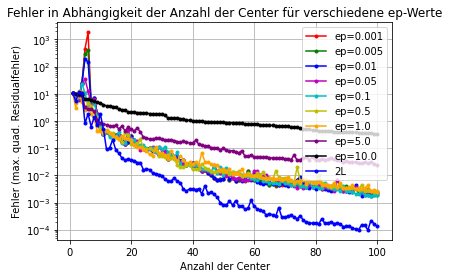

Kleinster MSE von VKOGA mit  0.00017334017625089294 von ep Wert:  0.005
Kleinster MSE von 2L-VKOGA mit  4.475684339475411e-06


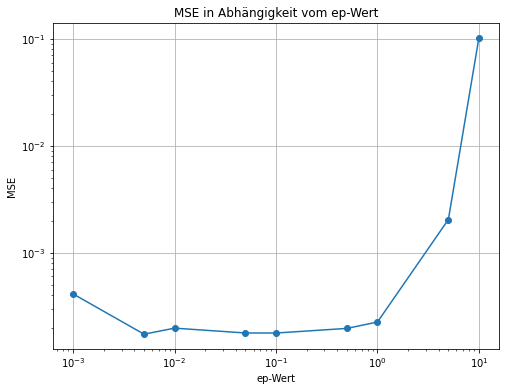

In [7]:
ep_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange', 'purple', 'k', 'b']
mse_list = []

for i, ep in enumerate(ep_values):
    model = VKOGA_2L(
        kernel=kernels.Matern(k=1, ep=ep),
        flag_2L_optimization=False,
        verbose=False,
        greedy_type='f_greedy',
        reg_par=0,
        restr_par=1e-2,
        tol_f=1e-10,
        tol_p=1e-10,
        reg_para_optim=1e-5,
        learning_rate=5e-3,
        n_epochs_optim=100,
        batch_size=32,
        flag_optim_verbose=False
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test).flatten()
    mse = np.mean((predictions - y_test.numpy()) ** 2)
    mse_list.append(mse)
    plt.plot(model.train_hist['n'], model.train_hist['f'], marker='.', color=colors[i], label=f'ep={ep}')
plt.plot(model_2L.train_hist['n'], model_2L.train_hist['f'], marker='.', color=colors[-1], label=f'2L')

plt.xlabel('Anzahl der Center')
plt.ylabel('Fehler (max. quad. Residualfehler)')
plt.title('Fehler in Abhängigkeit der Anzahl der Center für verschiedene ep-Werte')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

min_mse = min(mse_list)
best_ep = mse_list.index(min_mse)
print("Kleinster MSE von VKOGA mit ", min_mse, "von ep Wert: ", ep_values[best_ep])
print("Kleinster MSE von 2L-VKOGA mit ", mse_2L)
plt.figure(figsize=(8, 6))
plt.plot(ep_values, mse_list, marker='o', linestyle='-')
plt.xlabel("ep-Wert")
plt.ylabel("MSE")
plt.title("MSE in Abhängigkeit vom ep-Wert")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

In [8]:
X, y = generate_data(size=(50000, 4), function=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X[:5])
print(y[:5])

tensor([[0.5261, 0.1579, 0.6732, 0.5689],
        [0.1831, 0.2568, 0.9708, 0.6729],
        [0.5633, 0.6340, 0.9191, 0.0761],
        [0.3028, 0.8678, 0.2105, 0.1667],
        [0.0090, 0.1670, 0.7456, 0.5059]])
tensor([1.0552, 1.1332, 0.8859, 1.1438, 0.8557])


In [9]:
# Initialize and fit VKOGA_2L model
model_2L = VKOGA_2L(
    kernel=[kernels.Matern(k=1), tkernels.Matern(k=1)], # quadratic Matern kernel used
    flag_2L_optimization=True,
    verbose=False,
    greedy_type='f_greedy',
    reg_par=0,
    restr_par=1e-2,
    tol_f=1e-10,
    tol_p=1e-10,
    reg_para_optim=1e-5,
    learning_rate=5e-3,
    n_epochs_optim=25,
    batch_size=64,
    flag_optim_verbose=False
)

model_2L.fit(X_train, y_train)

# Print some predictions and ground truth
predictions = model_2L.predict(X_test)
predictions = predictions.flatten()
print("Predictions:", predictions[:5])
print("Ground truth:", y_test[:5])

# Print Error
mse_2L = np.mean((predictions - y_test.numpy()) ** 2)
print(f"MSE on Test Data: {mse_2L}")
print(f"Transformationmatrix: {model_2L.A.round(decimals=3)}")
U, S, VT = np.linalg.svd(model_2L.A.round(decimals=3))
print("Singulärwerte (S):", S.round(decimals=3))
print("Linke singuläre Vektoren (U):\n", U.round(decimals=3))
print("Rechte singuläre Vektoren (V^T):\n", VT.round(decimals=3))

Predictions: [1.38806999 0.92892936 1.35345038 1.02062651 1.3888442 ]
Ground truth: tensor([1.3857, 0.9210, 1.3528, 1.0223, 1.3874])
MSE on Test Data: 1.5731615269871586e-05
Transformationmatrix: [[ 0.124  0.375 -0.009 -0.032]
 [ 0.116  0.368 -0.033  0.009]
 [-0.081  0.015  0.154  0.011]
 [ 0.154 -0.043  0.045 -0.01 ]]
Singulärwerte (S): [0.554 0.188 0.151 0.029]
Linke singuläre Vektoren (U):
 [[-0.715 -0.036 -0.094 -0.692]
 [-0.698 -0.014  0.073  0.712]
 [ 0.039 -0.776 -0.624  0.086]
 [-0.009  0.629 -0.773  0.082]]
Rechte singuläre Vektoren (V^T):
 [[-0.315 -0.947  0.063  0.031]
 [ 0.818 -0.306 -0.481 -0.073]
 [-0.474  0.1   -0.874  0.03 ]
 [ 0.084  0.004 -0.011  0.996]]


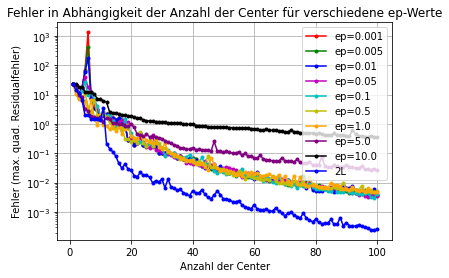

Kleinster MSE von VKOGA mit  0.0003071275463195598 von ep Wert:  0.05
Kleinster MSE von 2L-VKOGA mit  1.5731615269871586e-05


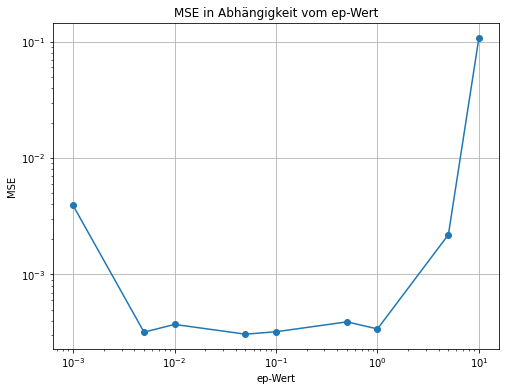

In [10]:
ep_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange', 'purple', 'k', 'b']
mse_list = []

for i, ep in enumerate(ep_values):
    model = VKOGA_2L(
        kernel=kernels.Matern(k=1, ep=ep),
        flag_2L_optimization=False,
        verbose=False,
        greedy_type='f_greedy',
        reg_par=0,
        restr_par=1e-2,
        tol_f=1e-10,
        tol_p=1e-10,
        reg_para_optim=1e-5,
        learning_rate=5e-3,
        n_epochs_optim=100,
        batch_size=32,
        flag_optim_verbose=False
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test).flatten()
    mse = np.mean((predictions - y_test.numpy()) ** 2)
    mse_list.append(mse)
    plt.plot(model.train_hist['n'], model.train_hist['f'], marker='.', color=colors[i], label=f'ep={ep}')
plt.plot(model_2L.train_hist['n'], model_2L.train_hist['f'], marker='.', color=colors[-1], label=f'2L')

plt.xlabel('Anzahl der Center')
plt.ylabel('Fehler (max. quad. Residualfehler)')
plt.title('Fehler in Abhängigkeit der Anzahl der Center für verschiedene ep-Werte')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

min_mse = min(mse_list)
best_ep = mse_list.index(min_mse)
print("Kleinster MSE von VKOGA mit ", min_mse, "von ep Wert: ", ep_values[best_ep])
print("Kleinster MSE von 2L-VKOGA mit ", mse_2L)
plt.figure(figsize=(8, 6))
plt.plot(ep_values, mse_list, marker='o', linestyle='-')
plt.xlabel("ep-Wert")
plt.ylabel("MSE")
plt.title("MSE in Abhängigkeit vom ep-Wert")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()